# mmFace + InsightFace2D Hybrid Model

## Build and Load Dataset

Real Dataset:
- 21 Subjects, 15 Experiments
  * Total 250 data frames -> Shuffle -> Take first 15 frames and split
  * Total 10 RGB embeddings -> Filter undetected -> Shuffle and Fill 15 frames and split

`15*15*21 = 4725 Data Points`

Fake Dataset:
- 21 Subjects, 3 Experiments
  * Total 74 ARD frames -> Shuffle -> Split
  * Total 10 RGB embeddings -> Filter undetected -> Shuffle and Fill 74 frames and split

`74*3*21 = 4662 Data Points`

`NB: If no RGB embedding for an subject experiment, need to completely remove that`

In [1]:
from hybrid_dataset import load_dataset, load_dataset_subject, load_aug_dataset_subject
from tqdm import tqdm
import numpy as np
import torch
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device, '\n')

RAW_PATH = os.path.relpath("../../Soli/soli_realsense/data")
num_subjects = 21

torch.cuda.empty_cache()
# train, validation, test = load_dataset(RAW_PATH, num_subjects, device=device)
# train, validation, test = load_dataset_subject(RAW_PATH, num_subjects, train_split=15/21, test_split=3/21, device=device)
train, test, test_idx, test_exp = load_aug_dataset_subject(RAW_PATH, num_subjects, device=device)

Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CUDAExecutionProvider': {'do_copy_in_default_stream': '1', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'device_id': '0', 'gpu_external_alloc': '0', 'enable_cuda_graph': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_free': '0', 'gpu_external_empty_cache': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'cudnn_conv_use_max_workspace': '1', 'cudnn_conv1d_pad_to_nc1d': '0', 'tunable_op_enable': '0', 'tunable_op_tuning_enable': '0', 'enable_skip_layer_norm_strict_mode': '0'}, 'CPUExecutionProvider': {}}
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CUDAExecutionProvider': {'do_copy_in_default_stream': '1', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'device_id': '0', 'gpu_external_alloc': '0', 'enable_cuda_graph': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_free': '0', 'gpu_external_empty_cache': '0', 'arena_extend_strategy': 'kNextPowerOfTwo',

## Model Creation and Loading

In [2]:
from neural_nets import MMFace, concatenate, add, hadamard_product, pairwise_dot_mean, pairwise_dot_max, pairwise_dot_flatten, multihead_attention, radar, rgb
from utils import load_model, load_history
from torch import nn

num_epochs = 5
learning_rate = 0.01

lambda1, lambda2 = 1, 1

# All fusion methods run for 15-20 epochs
model = MMFace(num_subjects, fuse=pairwise_dot_flatten).to(device)

# Loss + Optimiser
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.001, momentum=0.9)

model_name = f"mmFace-pairwise_dot_flatten-MORE_LAYERS2.pt"
cur_epoch, loss_history, train_acc, val_acc = load_model(model_name, model, optimiser)

if len(loss_history) > 0:
    print(f"{model_name}\n\tEpoch: {cur_epoch}\n\tLoss: {loss_history[-1]:.4f}\n\tTrain Accuracy: {train_acc[-1]}\n\tValidation Accuracy: {val_acc}")

[Errno 2] No such file or directory: 'models/mmFace-pairwise_dot_flatten-MORE_LAYERS2.pt'


## Training

In [3]:
for epoch in range(cur_epoch, num_epochs):
    print(f"\nEpoch [{epoch}/{num_epochs-1}]:")
    if os.path.exists(f"models/{model_name}"):
        loss_history, train_acc, val_acc = load_history(f"models/{model_name}")

    model.train()
    # Running Loss and Accuracy
    running_loss, running_acc_s, running_acc_l, total_s, total_l = 0., 0., 0., 0., 0.

    for radar, rgb_emb, labels_s, labels_l in tqdm(train):
        # Forward Pass
        out1, out2 = model(radar, rgb_emb)
        _, preds_s = torch.max(out1.data, 1)
        _, preds_l = torch.max(out2.data, 1)
        loss1 = criterion(out1, labels_s)
        loss2 = criterion(out2, labels_l)
        loss = lambda1*loss1 + lambda2*loss2

        # Backward Pass and Optimise
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        running_loss += loss.item()
        total_s += labels_s.size(0)
        total_l += labels_l.size(0)
        running_acc_s += (preds_s == labels_s).sum().item()
        running_acc_l += (preds_l == labels_l).sum().item()

        del radar, rgb_emb, labels_s, labels_l, out1, out2
        torch.cuda.empty_cache()
    
    avg_train_loss = running_loss/len(train)
    avg_train_acc_s = 100*running_acc_s/total_s
    avg_train_acc_l = 100*running_acc_l/total_l
    print(f"\tAverage Train Loss: {avg_train_loss:.4f}")
    print(f"\tTrain Accuracy (Subjects): {avg_train_acc_s:.4f}%")
    print(f"\tTrain Accuracy (Liveness): {avg_train_acc_l:.4f}%")

    torch.save({"epoch": epoch+1,
                "model_state_dict": model.state_dict(),
                "optimiser_state_dict": optimiser.state_dict(),
                "loss_history": loss_history + [avg_train_loss],
                "train_acc": train_acc + [(avg_train_acc_s, avg_train_acc_l)],
                "val_acc": val_acc},
                f"models/{model_name}")


Epoch [0/4]:


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:05<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 GiB. GPU 0 has a total capacty of 4.00 GiB of which 0 bytes is free. Of the allocated memory 6.26 GiB is allocated by PyTorch, and 61.90 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## Testing

### Load Models for Inference

In [14]:
from neural_nets import MMFace, concatenate, add, hadamard_product, pairwise_dot_mean, pairwise_dot_max, pairwise_dot_flatten, multihead_attention, radar, rgb
from utils import load_model

del model
model = MMFace(num_subjects, fuse=multihead_attention).to(device)

model_name = f"mmFace-multihead_attention.pt"
cur_epoch, loss_history, train_acc, val_acc = load_model(model_name, model, torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001, momentum=0.9))

if len(loss_history) > 0:
    print(f"{model_name}\n\tEpoch: {cur_epoch}\n\tLoss: {loss_history[-1]:.4f}\n\tTrain Accuracy: {train_acc[-1]}\n\tValidation Accuracy: {val_acc}")

mmFace-multihead_attention.pt
	Epoch: 10
	Loss: 0.0106
	Train Accuracy: (99.98999699909973, 100.0)
	Validation Accuracy: []


### Zero-Shot Testing

In [15]:
from hybrid_dataset import get_ard_aug, get_rgb_emb_aug

test_subjects = [i if i < num_subjects else int(f"9{(i-num_subjects)}") for i in test_idx]
print(test_subjects)

# Gather raw reference data (Taking frame 7 of ARD and RGB embedding of 0°,RLC,NO)
f = 7
exp = 0
print(f"Frame: {f} | Experiment: {exp}")
references_raw = [(torch.tensor(get_ard_aug(RAW_PATH, sub, exp, 250, "none")[f], device=device).unsqueeze(0), 
                   torch.tensor(get_rgb_emb_aug(RAW_PATH, sub, exp, "none", set())[f], device=device, dtype=torch.float32).unsqueeze(0)) for sub in tqdm(test_subjects)]

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.eval()
# Hook to get last layer feature embeddings
model.fc_hybrid1.register_forward_hook(get_activation("fc_hybrid1"))

reference_embs = np.zeros((len(references_raw), 64))
unseen_embeddings, true_labels_s, true_labels_l = [], [], []

with torch.no_grad():
    for i, raw_inputs in enumerate(references_raw):
        _ = model(*raw_inputs)
        reference_embs[i] = activation["fc_hybrid1"].detach().cpu().numpy()

    for radar, rgb_emb, subjects, liveness in test:
        _ = model(radar, rgb_emb)
        unseen_embeddings.append(activation["fc_hybrid1"].detach().cpu().numpy())
        true_labels_s.append(subjects.detach().cpu().numpy())
        true_labels_l.append(liveness.detach().cpu().numpy())


ref_labels_s = [idx if idx < num_subjects else idx-num_subjects for idx in test_idx]
ref_labels_l = [1 if idx < num_subjects else 0 for idx in test_idx]

unseen_embeddings = np.concatenate(unseen_embeddings)
true_labels_s = np.concatenate(true_labels_s, dtype=np.int32)
true_labels_l = np.concatenate(true_labels_l, dtype=np.int32)

[20, 2, 5, 15, 920, 92, 95, 915]
Frame: 7 | Experiment: 0


100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


In [16]:
from sklearn.metrics import confusion_matrix

def cos_sim(x, Y):
    return x @ Y.T / (np.linalg.norm(x)*np.linalg.norm(Y, axis=1))

def search_flatten(reference_embs, unseen_embeddings, labels1, labels2, t=0.5, max_t=0.999):
    preds = []
    for emb in unseen_embeddings:
        scores = cos_sim(emb, reference_embs)
        scores = np.clip(scores, 0., 1.)
        # Ensure scores >= max threshold are discarded
        l1 = np.array(labels1)[scores < max_t]
        l2 = np.array(labels2)[scores < max_t]
        scores = scores[scores < max_t]

        idx = np.argmax(scores)
        if scores[idx] > t:
            preds.append((l1[idx], l2[idx]))
        else:
            preds.append((None, None))
    
    return preds

def evaluate(true_labels, pred_labels, labels):
    coverage = np.mean([n != -1 for n in pred_labels]) * 100.
    is_corrects = [t == p for t, p in zip(true_labels, pred_labels) if p != -1]
    if not is_corrects:
        is_corrects.append(False)

    accuracy = np.mean(is_corrects) * 100.

    cfm = confusion_matrix(true_labels, pred_labels, labels=labels)

    return accuracy, coverage, cfm

preds_s, preds_l = list(zip(*search_flatten(reference_embs, unseen_embeddings, ref_labels_s, ref_labels_l, t=0.5)))

test_classes_s = sorted(ref_labels_s[:len(ref_labels_s)//2]) + [-1]
test_classes_l = [0, 1, -1]

preds_s_norm = np.array(preds_s)
preds_s_norm[np.where(preds_s_norm == None)[0]] = -1
preds_s_norm = np.array(preds_s_norm, dtype=np.int32)

preds_l_norm = np.array(preds_l)
preds_l_norm[np.where(preds_l_norm == None)[0]] = -1
preds_l_norm = np.array(preds_l_norm, dtype=np.int32)

acc_subject, cov_subject, cfm_subject = evaluate(true_labels_s, preds_s_norm, test_classes_s)
acc_liveness, cov_liveness, cfm_liveness = evaluate(true_labels_l, preds_l_norm, test_classes_l)

print(f"Zero-shot Test ({model_name}):")
print(f"\tSUBJECT - Accuracy: {acc_subject:.4f}% | Coverage: {cov_subject:.4f}%")
print(f"\tLIVENESS - Accuracy: {acc_liveness:.4f}% | Coverage: {cov_liveness:.4f}%")

Zero-shot Test (mmFace-pairwise_dot_flatten-MORE_LAYERS.pt):
	SUBJECT - Accuracy: 84.9602% | Coverage: 97.0299%
	LIVENESS - Accuracy: 97.2523% | Coverage: 97.0299%


### Precision, Recall and F-Scores

[2, 5, 15, 20, -1]


C:\Users\jovin\AppData\Local\Temp\ipykernel_12408\2737236844.py:20: RuntimeWarning: invalid value encountered in divide
  df_cm_r = pd.DataFrame(cfm_subject / np.sum(cfm_subject, axis=1)[:, None], index=subject_names, columns=subject_names)


[Text(0.5, 25.722222222222214, 'F1 Score'), Text(0.5, 1.0, 'F1 Scores')]

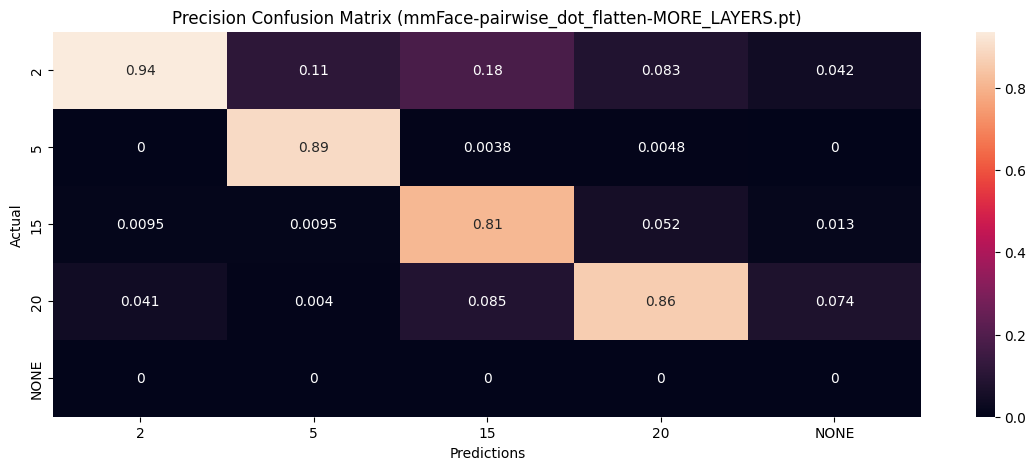

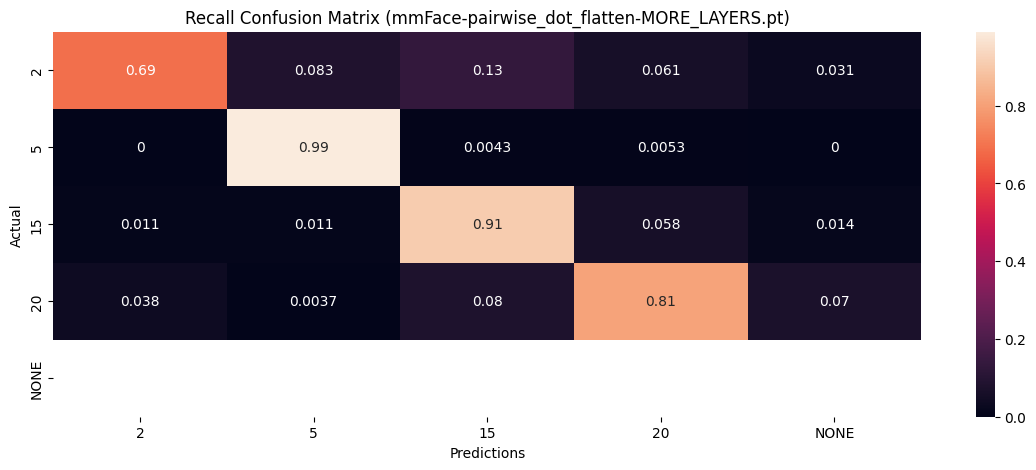

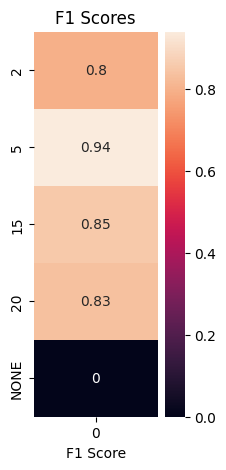

In [7]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import sys
sys.path.insert(1, "../../Soli/soli_realsense/")
from names import anon_names

# subject_names = list(np.array(anon_names)[test_classes_s[:-1]])+["NONE"]
subject_names = test_classes_s[:-1]+["NONE"]

print(test_classes_s)
# PRECISION: Measure of quality: Ratio of getting guess correct out of the number of times it guessed that class
df_cm_p = pd.DataFrame(cfm_subject / np.sum(cfm_subject, axis=0)[:, None], index=subject_names, columns=subject_names)
plt.figure(figsize=(14, 5))
heatmap_p = sn.heatmap(df_cm_p, annot=True)
heatmap_p.set(xlabel="Predictions", ylabel="Actual", title=f"Precision Confusion Matrix ({model_name})")

# RECALL: Measure of quantity: Ratio of getting guess correct out of the number of actual items in class
df_cm_r = pd.DataFrame(cfm_subject / np.sum(cfm_subject, axis=1)[:, None], index=subject_names, columns=subject_names)
plt.figure(figsize=(14, 5))
heatmap_r = sn.heatmap(df_cm_r, annot=True)
heatmap_r.set(xlabel="Predictions", ylabel="Actual", title=f"Recall Confusion Matrix ({model_name})")

df_f1 = pd.DataFrame(f1_score(true_labels_s, preds_s_norm, labels=test_classes_s, average=None), index=subject_names)
plt.figure(figsize=(2, 5))
heatmap_f1 = sn.heatmap(df_f1, annot=True)
heatmap_f1.set(xlabel="F1 Score", title="F1 Scores")

C:\Users\jovin\AppData\Local\Temp\ipykernel_12408\503475060.py:13: RuntimeWarning: invalid value encountered in divide
  df_cm_r = pd.DataFrame(cfm_liveness / np.sum(cfm_liveness, axis=1)[:, None], index=liveness_names, columns=liveness_names)


[Text(0.5, 3.722222222222216, 'F1 Score'), Text(0.5, 1.0, 'F1 Scores')]

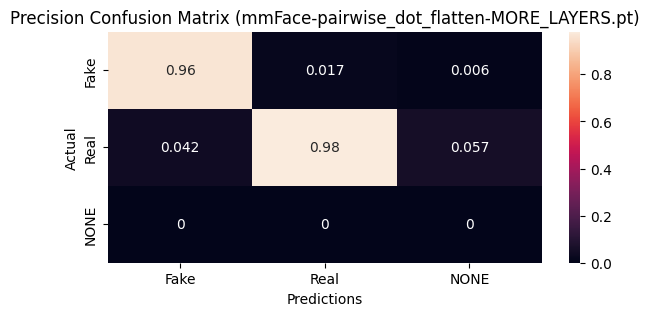

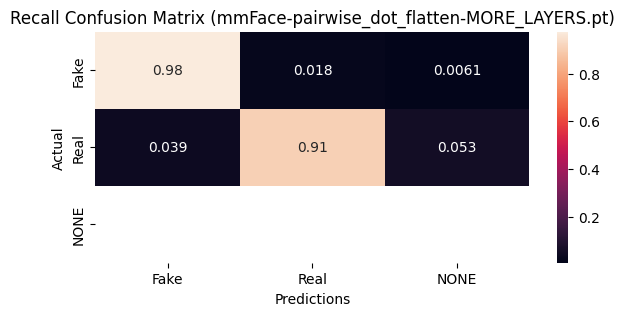

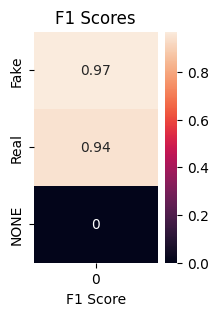

In [8]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

liveness_names = ["Fake", "Real", "NONE"]

df_cm_p = pd.DataFrame(cfm_liveness / np.sum(cfm_liveness, axis=0)[:, None], index=liveness_names, columns=liveness_names)
plt.figure(figsize = (7, 3))
heatmap_p = sn.heatmap(df_cm_p, annot=True)
heatmap_p.set(xlabel="Predictions", ylabel="Actual", title=f"Precision Confusion Matrix ({model_name})")

df_cm_r = pd.DataFrame(cfm_liveness / np.sum(cfm_liveness, axis=1)[:, None], index=liveness_names, columns=liveness_names)
plt.figure(figsize = (7, 3))
heatmap_r = sn.heatmap(df_cm_r, annot=True)
heatmap_r.set(xlabel="Predictions", ylabel="Actual", title=f"Recall Confusion Matrix ({model_name})")

df_f1 = pd.DataFrame(f1_score(true_labels_l, preds_l_norm, labels=test_classes_l, average=None), index=liveness_names)
plt.figure(figsize=(2, 3))
heatmap_f1 = sn.heatmap(df_f1, annot=True)
heatmap_f1.set(xlabel="F1 Score", title="F1 Scores")

In [9]:
from sklearn.metrics import f1_score

micro_f1_s = f1_score(true_labels_s, preds_s_norm, labels=test_classes_s, average="micro")
micro_f1_l = f1_score(true_labels_l, preds_l_norm, labels=test_classes_l, average="micro")
print(f"Micro-Averaged F1 Score (Subject): {micro_f1_s:.4f}")
print(f"Micro-Averaged F1 Score (Liveness): {micro_f1_l:.4f}")

Micro-Averaged F1 Score (Subject): 0.8431
Micro-Averaged F1 Score (Liveness): 0.9422


In [10]:
from sklearn.metrics import fbeta_score

beta = 0.5

weighted_fb_s = fbeta_score(true_labels_s, preds_s_norm, beta=beta, labels=test_classes_s, average="weighted")
weighted_fb_l = fbeta_score(true_labels_l, preds_l_norm, beta=beta, labels=test_classes_l, average="weighted")
print(f"Weighted-Averaged F_{{{beta}}} Score (Subject): {weighted_fb_s:.4f}")
print(f"Weighted-Averaged F_{{{beta}}} Score (Liveness): {weighted_fb_l:.4f}")

Weighted-Averaged F_{0.5} Score (Subject): 0.8639
Weighted-Averaged F_{0.5} Score (Liveness): 0.9650


In [11]:
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(true_labels_l, preds_l_norm, labels=test_classes_l)

c:\Users\jovin\Documents\Computer Science (FR)\Year 5\Level 5 Individual Project\mmFace-3D-Face-Recognition-using-RGB-and-mmWave-Radar\3dfr\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.99765588, 0.99124939, 0.        ]),
 array([0.9916123, 0.957277 , 0.       ]),
 array([0.99462491, 0.97396704, 0.        ]),
 array([2146, 2130,    0], dtype=int64))

In [10]:
from sklearn.metrics import classification_report
print(classification_report(true_labels_s, preds_s_norm, digits=3))
print(classification_report(true_labels_l, preds_l_norm, digits=3))

              precision    recall  f1-score   support

          -1      0.000     0.000     0.000         0
           2      0.916     0.693     0.789      1132
           5      0.855     0.974     0.911       939
          15      0.750     0.863     0.802      1132
          20      0.863     0.832     0.847      1073

    accuracy                          0.835      4276
   macro avg      0.677     0.672     0.670      4276
weighted avg      0.845     0.835     0.834      4276

              precision    recall  f1-score   support

          -1      0.000     0.000     0.000         0
           0      0.999     0.988     0.993      2146
           1      0.993     0.999     0.996      2130

    accuracy                          0.993      4276
   macro avg      0.664     0.662     0.663      4276
weighted avg      0.996     0.993     0.995      4276



c:\Users\jovin\Documents\Computer Science (FR)\Year 5\Level 5 Individual Project\mmFace-3D-Face-Recognition-using-RGB-and-mmWave-Radar\3dfr\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jovin\Documents\Computer Science (FR)\Year 5\Level 5 Individual Project\mmFace-3D-Face-Recognition-using-RGB-and-mmWave-Radar\3dfr\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jovin\Documents\Computer Science (FR)\Year 5\Level 5 Individual Project\mmFace-3D-Face-Recognition-using-RGB-and-mmWave-Radar\3dfr\lib\site-package

### ROC Curve and AUC

Macro-Averaged AUC: 0.9064


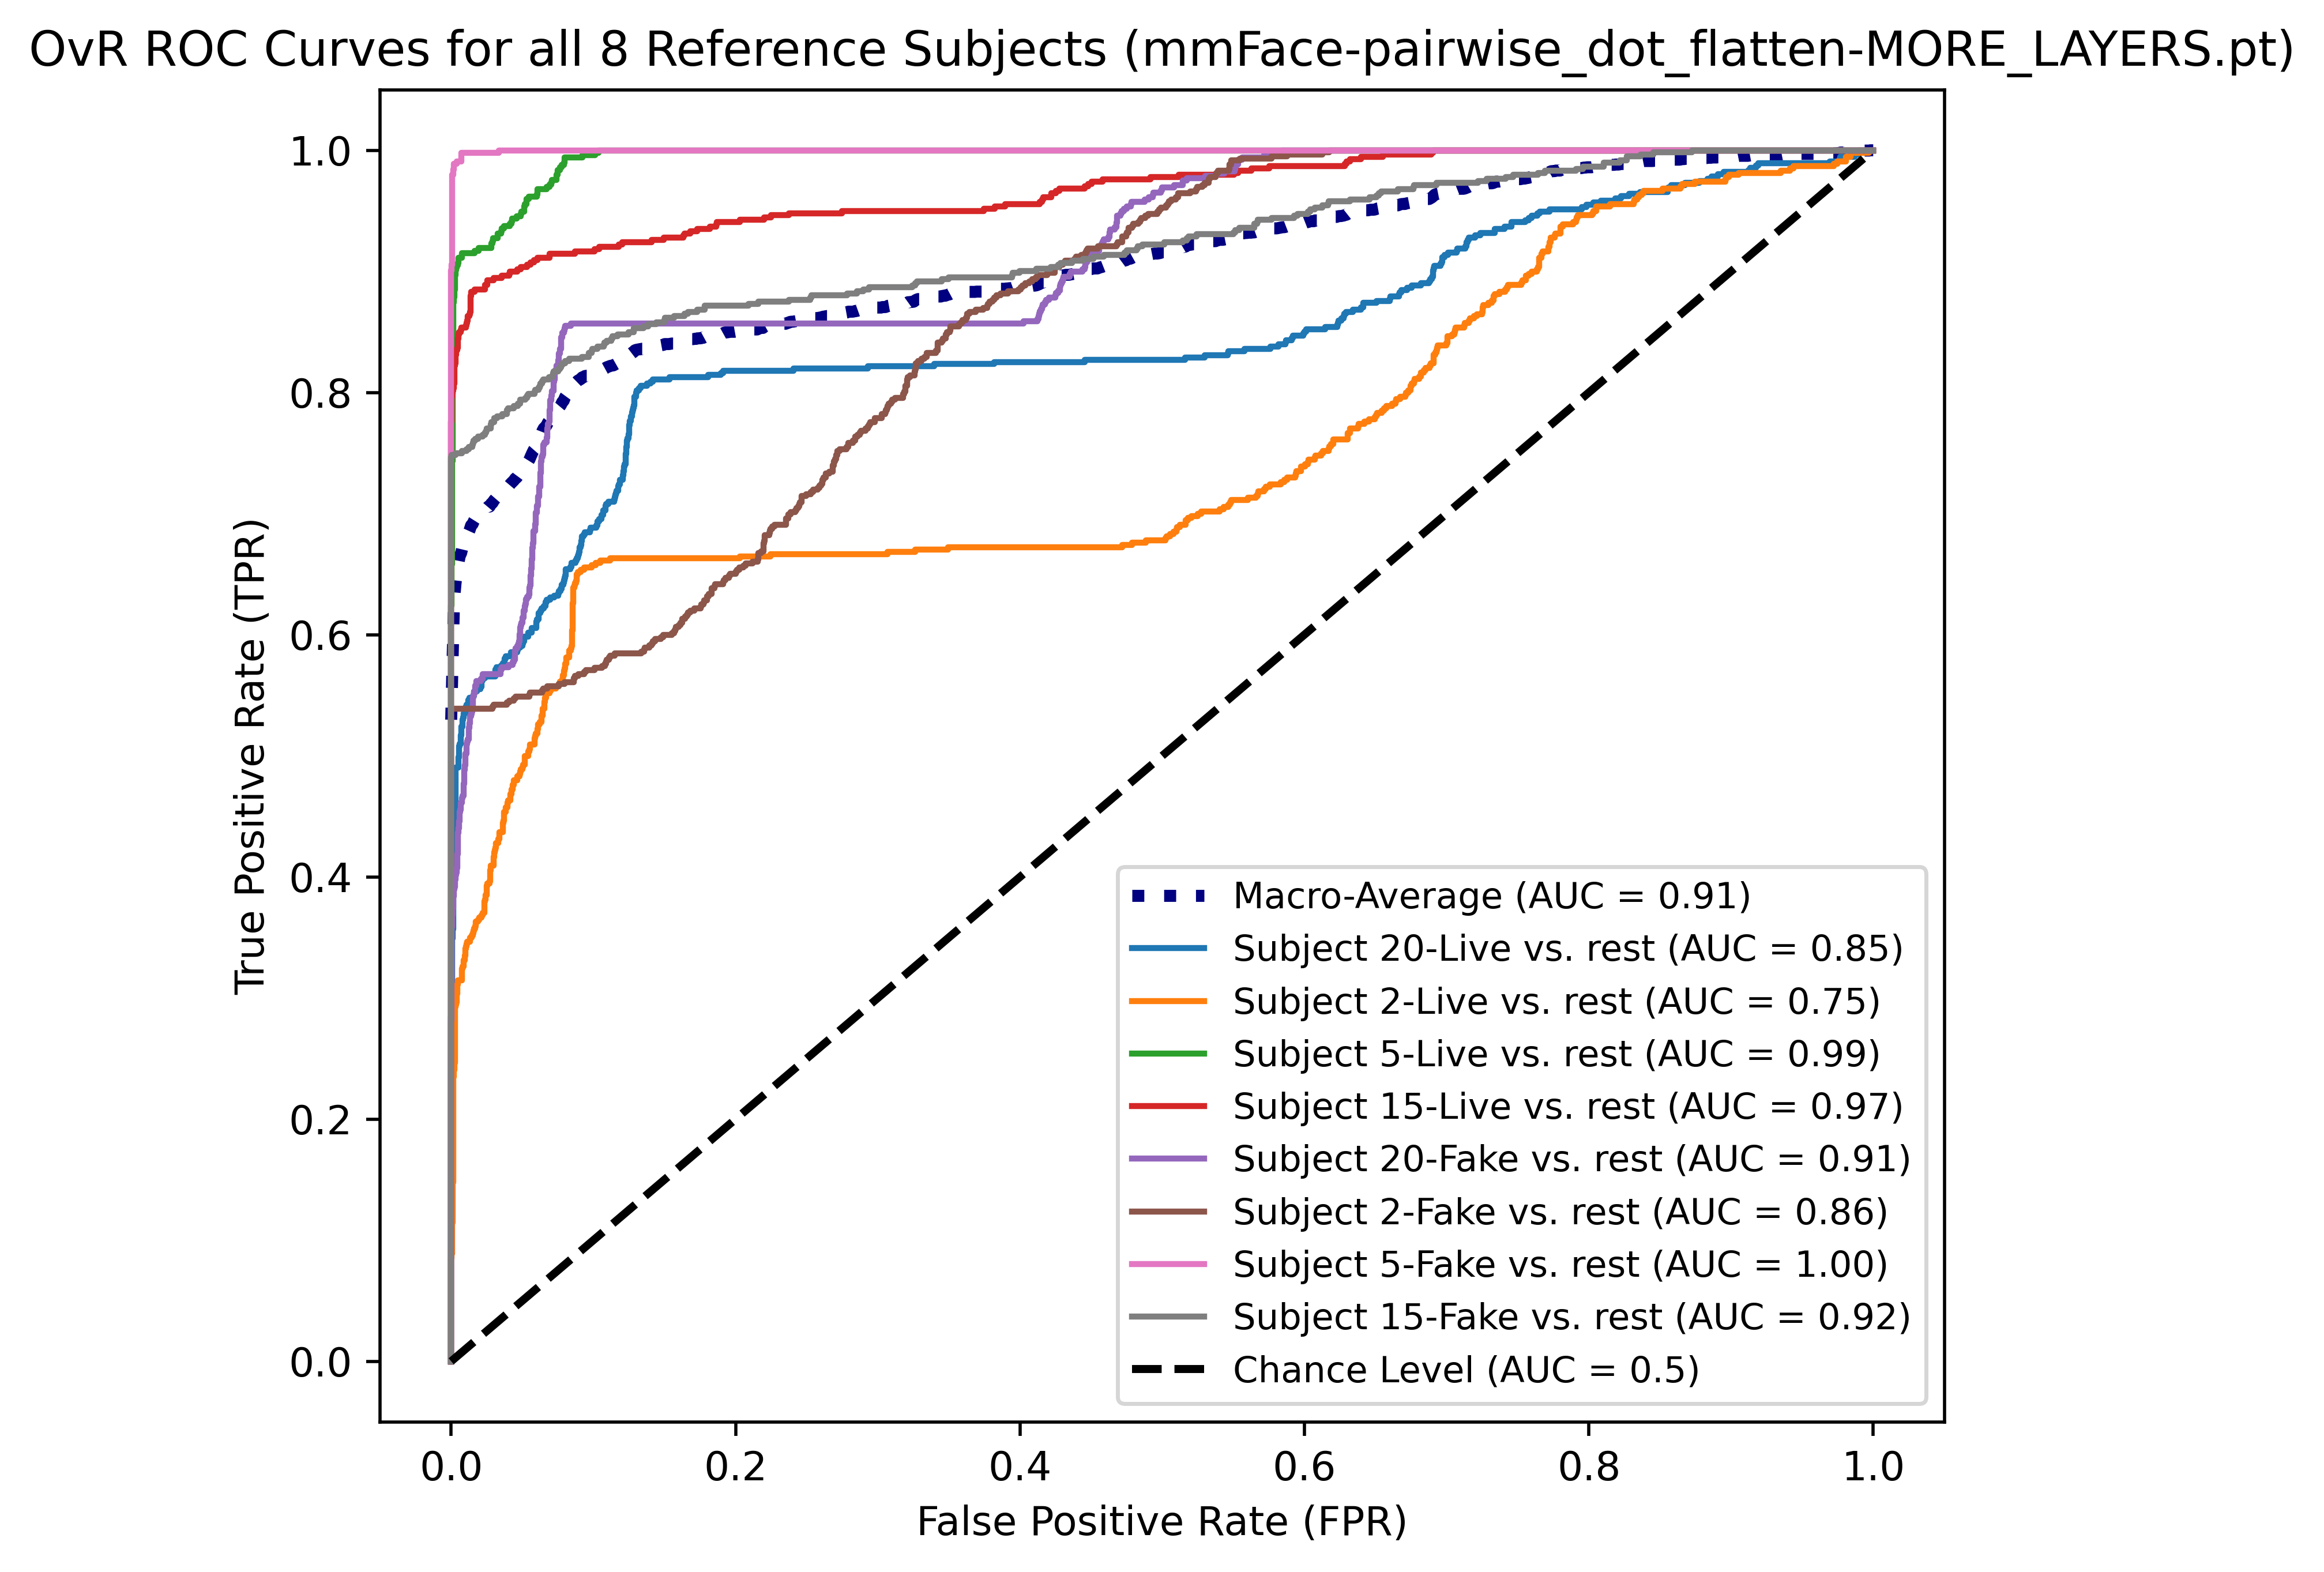

In [11]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import matplotlib.colors as mcolours

def sim_scores(reference_emb, unseen_embeddings):
    max_scores = []
    for emb in unseen_embeddings:
        score = cos_sim(emb, reference_emb)
        max_scores.append(score[0])
    
    return max_scores

def OVR_ROC_macro_average(reference_subs, reference_embs, unseen_embeddings, true_labels):
    fpr, tpr, roc_auc = {}, {}, {}

    fpr_grid = np.linspace(0., 1., 1000)
    mean_tpr = np.zeros_like(fpr_grid)
    
    for i, r in enumerate(reference_subs):
        scores = sim_scores(reference_embs[i, None], unseen_embeddings)
        true_onehot_r = [1 if l == r and l != -1 else 0 for l in true_labels]
        fpr[i], tpr[i], _ = roc_curve(true_onehot_r, scores)
        roc_auc[i] = auc(fpr[i], tpr[i])

        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])
    
    mean_tpr /= len(reference_subs)
    mean_roc_auc = auc(fpr_grid, mean_tpr)

    fpr["macro"], tpr["macro"], roc_auc["macro"] = fpr_grid, mean_tpr, mean_roc_auc

    return fpr, tpr, roc_auc

true_labels_combined = [s if true_labels_l[i] else s+num_subjects for i, s in enumerate(true_labels_s)]
fpr, tpr, roc_auc = OVR_ROC_macro_average(test_idx, reference_embs, unseen_embeddings, true_labels_combined)

fig, ax = plt.subplots(figsize=(7, 6), dpi=500)
ax.plot(fpr["macro"], tpr["macro"], label=f"Macro-Average (AUC = {roc_auc['macro']:.2f})", color="navy", linestyle=":", linewidth=3)

roc_colours = list(mcolours.TABLEAU_COLORS.values())
for i, r in enumerate(ref_labels_s):
    ax.plot(fpr[i], tpr[i], label=f"Subject {r}-{'Live' if i < len(ref_labels_s)//2 else 'Fake'} vs. rest (AUC = {roc_auc[i]:.2f})", color=roc_colours[i])

ax.plot([0, 1], [0, 1], label="Chance Level (AUC = 0.5)", color="black", linestyle="--", linewidth=2)
ax.set(xlabel="False Positive Rate (FPR)", ylabel="True Positive Rate (TPR)", title=f"OvR ROC Curves for all 8 Reference Subjects ({model_name})")
ax.legend(fontsize="9")
print(f"Macro-Averaged AUC: {roc_auc['macro']:.4f}")

### t-SNE Visualisation

In [ ]:
train_embeddings, train_labels_s, train_labels_l = [], [], []
with torch.no_grad():
    for radar, rgb_emb, subjects, liveness in train:
        _ = model(radar, rgb_emb)
        train_embeddings.append(activation["fc_hybrid1"].detach().cpu().numpy())
        train_labels_s.append(subjects.detach().cpu().numpy())
        train_labels_l.append(liveness.detach().cpu().numpy())


train_embeddings = np.concatenate(train_embeddings)
train_labels_s = np.concatenate(train_labels_s, dtype=np.int32)
train_labels_l = np.concatenate(train_labels_l, dtype=np.int32)

In [ ]:
test_raw = []
with torch.no_grad():
    for radar, rgb_emb, subjects, liveness in test:
        test_raw.append(torch.concat((radar.view(radar.size(0), -1), rgb_emb), dim=1).detach().cpu().numpy())

test_raw = np.concatenate(test_raw)

In [12]:
from sklearn.manifold import TSNE

# Perplexities between 5-10 produce closer, circular clusters | Higher perplexities, distinct islands
# Hadamard Product: p=45, Concatenate: p=45, Multi-Head Attention: p=_
tsne = TSNE(n_components=2, perplexity=30)
X_tsne = tsne.fit_transform(unseen_embeddings)

# X_tsne = tsne.fit_transform(test_raw)
# X_tsne = tsne.fit_transform(train_embeddings)

print(f"KL Divergence ({model_name}): {tsne.kl_divergence_:.4f}")

KL Divergence (mmFace-pairwise_dot_flatten-MORE_LAYERS.pt): 0.3374


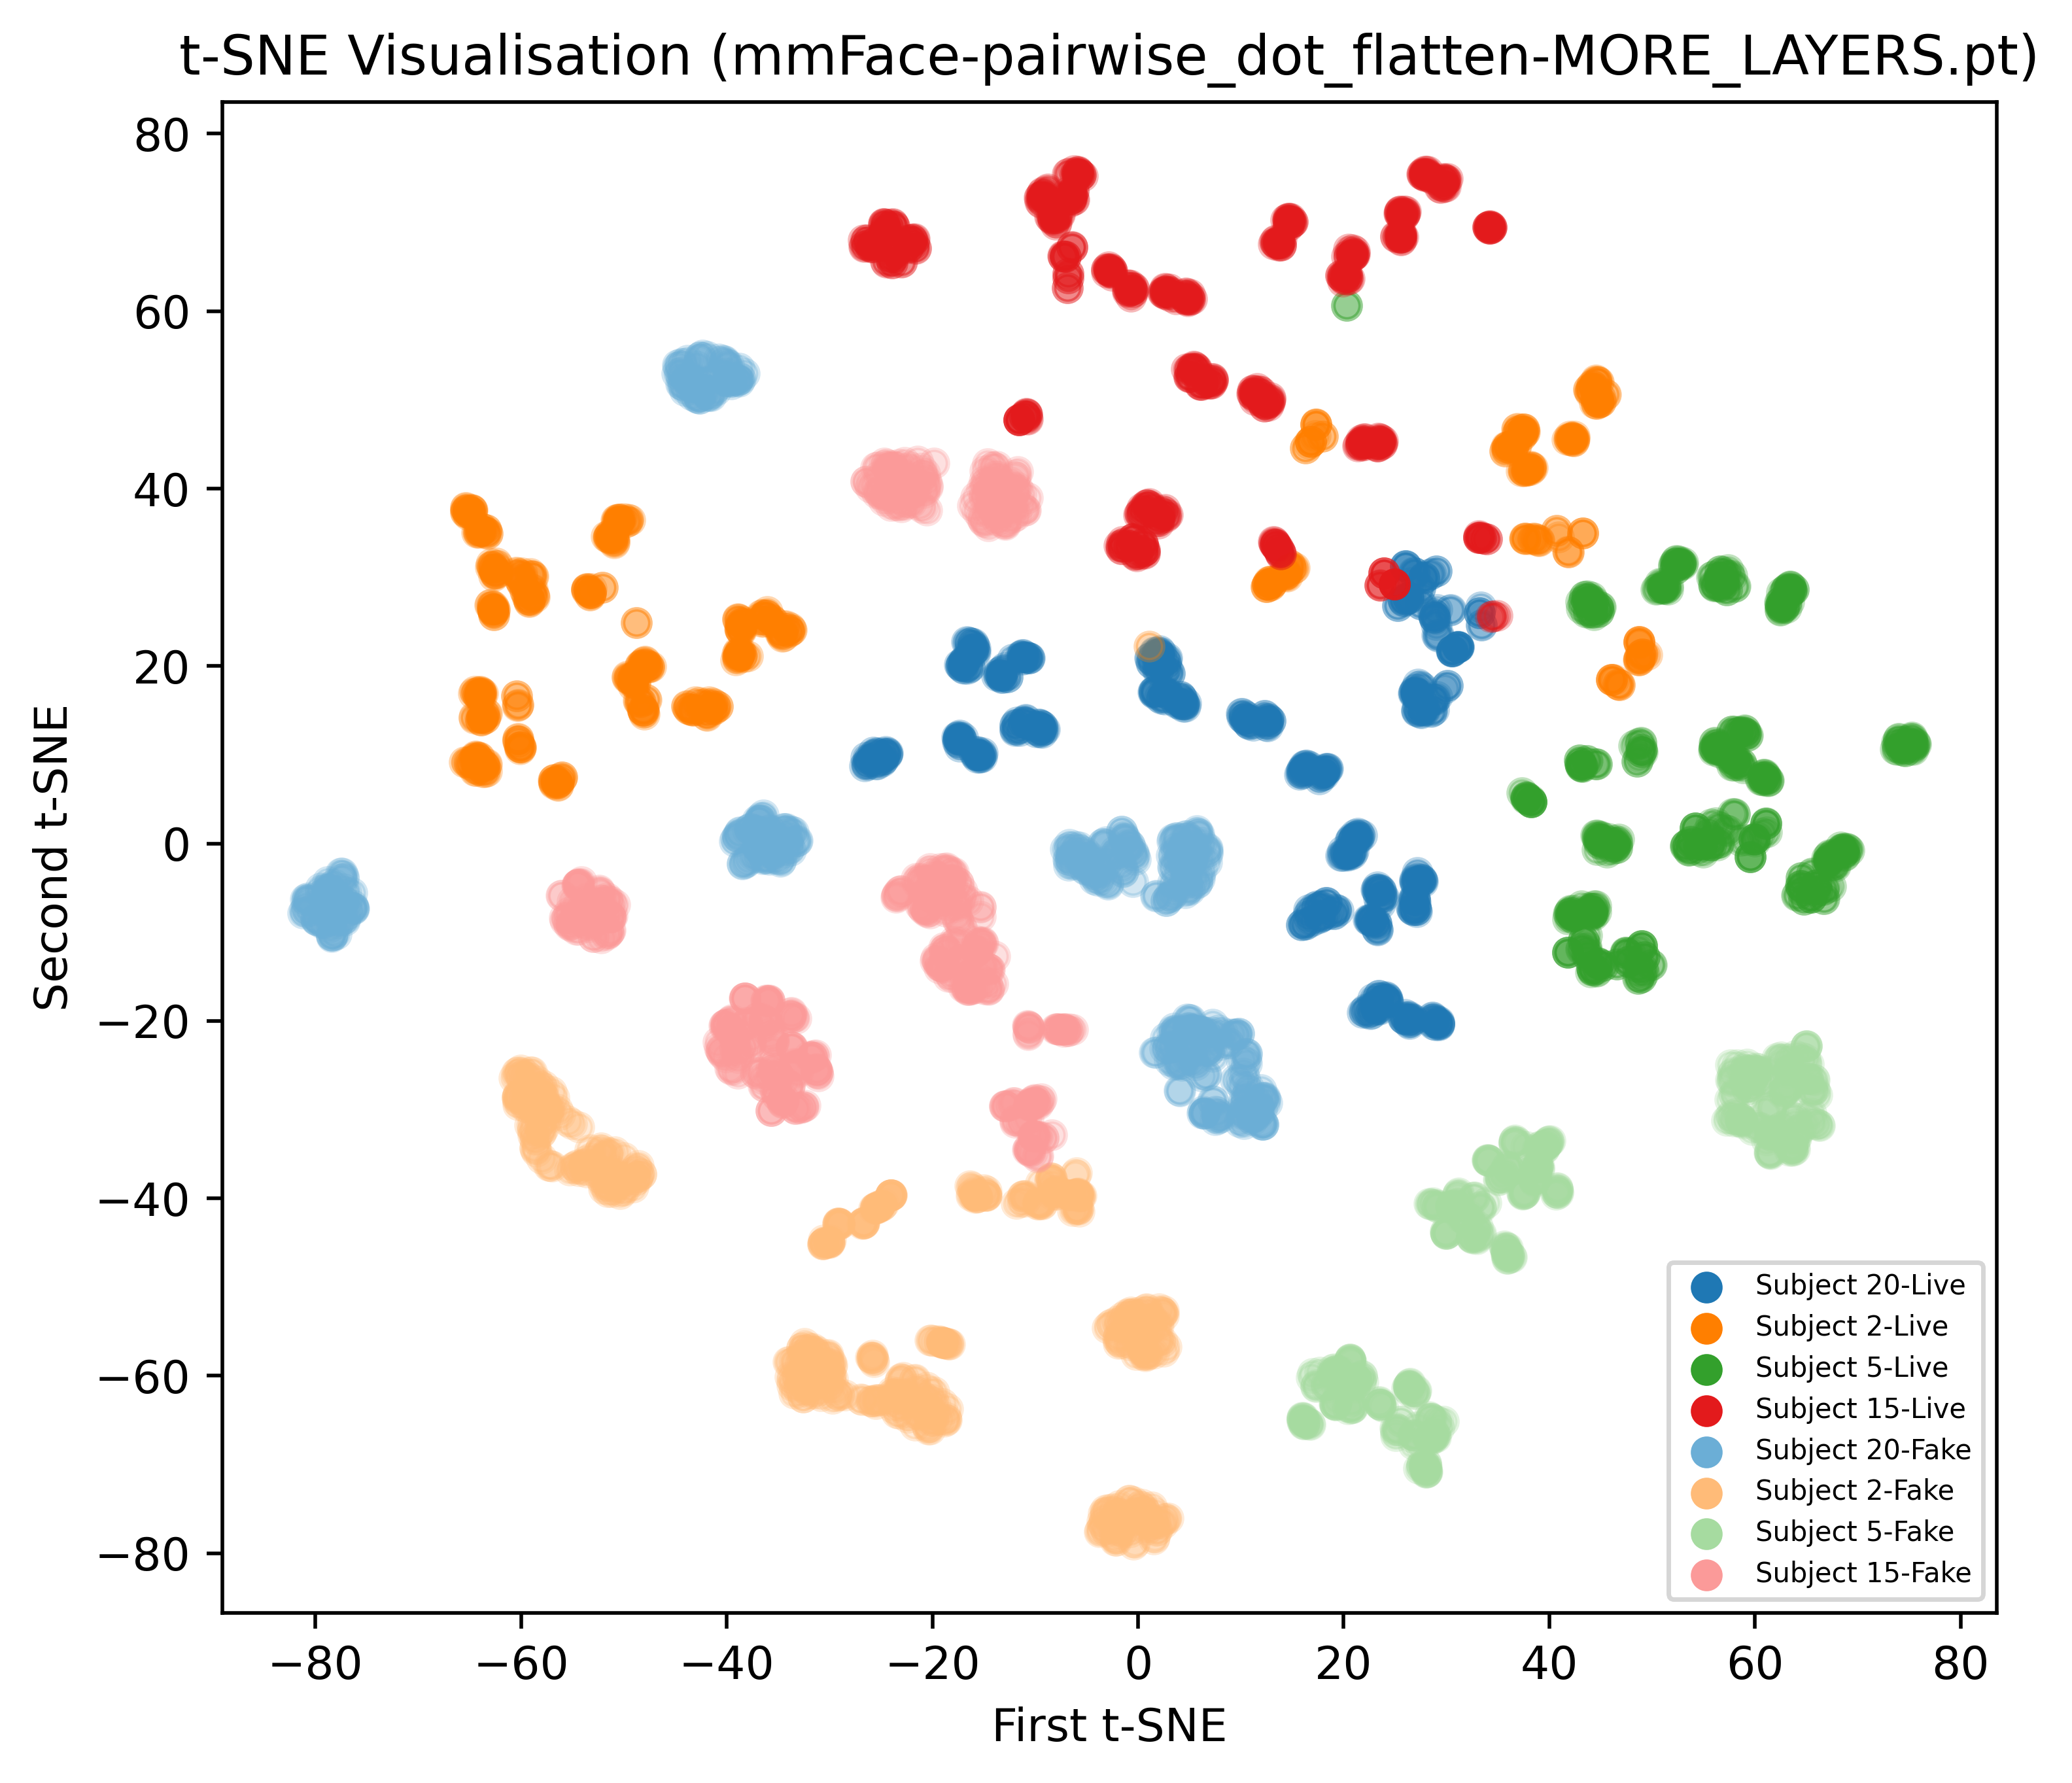

In [13]:
import matplotlib.pyplot as plt

# train_labels_set = list(set(train_labels_s))
# train_labels_norm = [train_labels_set.index(train_labels_s[i]) + (h if train_labels_l[i] else 0) for i in range(len(train_labels_s))]
# colours = np.array([list(mcolours.CSS4_COLORS.values())[i] for i in train_labels_norm])

h = len(ref_labels_s)//2
true_labels_norm = [ref_labels_s.index(true_labels_s[i]) + (0 if true_labels_l[i] else h) for i in range(len(true_labels_s))]

shades = [
    "#1f78b4",  # Blue
    "#ff7f00",  # Orange
    "#33a02c",  # Green
    "#e31a1c"   # Red
]

lighter_shades = [
    "#6baed6",  # Lighter shade of Blue
    "#ffbb78",  # Lighter shade of Orange
    "#a6dba0",  # Lighter shade of Green
    "#fb9a99"   # Lighter shade of Red
]

colours = np.array([shades[t] if true_labels_l[i] else lighter_shades[t % h] for i, t in enumerate(true_labels_norm)])

fig, ax = plt.subplots(figsize=(7, 6), dpi=500)
# ax = fig.add_subplot(projection="3d")
for i, colour in enumerate(shades + lighter_shades):
    indices = np.where(colours == colour)
    l = indices[0][0]
    
    ax.scatter(X_tsne[indices, 0], X_tsne[indices, 1], c=colour, label=f"Subject {true_labels_s[l]}-{'Live' if true_labels_l[l] else 'Fake'}", alpha=0.3
        )

plt.title(f"t-SNE Visualisation ({model_name})")
plt.xlabel("First t-SNE")
plt.ylabel("Second t-SNE")
legend = plt.legend(fontsize=6, loc="lower right")
for lh in legend.legend_handles:
    lh.set_alpha(1)
plt.show()

#### t-SNE Visualisation by Experiment

1073 1073


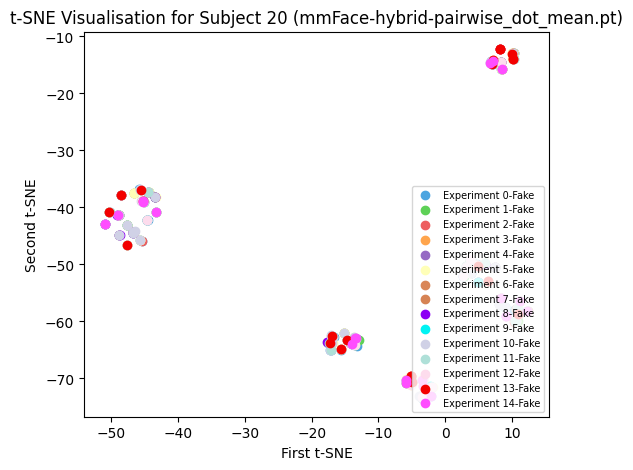

In [191]:
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import colorsys

def lighten_colour(colour, factor=0.7):
    """
    Lightens the given color by multiplying each RGB component by (1 + factor).
    """
    try:
        c = mc.cnames[colour]
    except:
        c = colour
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return mc.rgb2hex(colorsys.hls_to_rgb(c[0], 1 - factor * (1 - c[1]), c[2]))

shades = [
    "#1f78b4",  # Blue
    "#33a02c",  # Green
    "#e31a1c",  # Red
    "#ff7f00",  # Orange
    "#6a3d9a",  # Purple
    "#ffff99",  # Yellow
    "#b15928",  # Brown
    "#a65628",  # Copper
    "#4b0082",  # Indigo
    "#008080",  # Teal
    "#bcbddc",  # Lavender
    "#8dd3c7",  # Turquoise
    "#fccde5",  # Pink
    "#800000",  # Maroon
    "#FF00FF"   # Magenta
]

lighter_shades = [lighten_colour(c) for c in shades]

subject = ref_labels_s[0]
sub_indices = np.where(true_labels_s == subject)[0]

colours = np.array([shades[test_exp[i]] if true_labels_l[i] else lighter_shades[test_exp[i]] for i in sub_indices])
experiments = test_exp[sub_indices]
liveness_labels = true_labels_l[sub_indices]

print(len(colours), len(experiments))

fig, ax = plt.subplots(figsize=(6, 5), dpi=100)
for i, colour in enumerate(shades + lighter_shades):
    indices = np.where(colours == colour)
    l = indices[0][0]

    if not liveness_labels[l]:# and experiments[l] == 14:
        ax.scatter(X_tsne[sub_indices][indices, 0], X_tsne[sub_indices][indices, 1], c=colour, label=f"Experiment {experiments[l]}-{'Live' if liveness_labels[l] else 'Fake'}")

plt.title(f"t-SNE Visualisation for Subject {subject} ({model_name})")
plt.xlabel("First t-SNE")
plt.ylabel("Second t-SNE")
plt.legend(fontsize=7, loc="lower right")
plt.show()

## Model Performance Statistics

In [17]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    
count_parameters(model)

+---------------------+------------+
|       Modules       | Parameters |
+---------------------+------------+
|    conv1.0.weight   |    432     |
|     conv1.0.bias    |     16     |
|    conv1.1.weight   |     16     |
|     conv1.1.bias    |     16     |
|    conv2.0.weight   |    4608    |
|     conv2.0.bias    |     32     |
|    conv2.1.weight   |     32     |
|     conv2.1.bias    |     32     |
|    conv3.0.weight   |   18432    |
|     conv3.0.bias    |     64     |
|    conv3.1.weight   |     64     |
|     conv3.1.bias    |     64     |
|    conv4.0.weight   |   73728    |
|     conv4.0.bias    |    128     |
|    conv4.1.weight   |    128     |
|     conv4.1.bias    |    128     |
|     fc1.0.weight    |  2097152   |
|      fc1.0.bias     |    1024    |
|     fc1.1.weight    |    1024    |
|      fc1.1.bias     |    1024    |
|     fc2.0.weight    |   524288   |
|      fc2.0.bias     |    512     |
|     fc2.1.weight    |    512     |
|      fc2.1.bias     |    512     |
|

#### GPU Inference Time

In [9]:
*inputs, _, _ = next(iter(train))
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
repetitions = 1000
timings = np.zeros((repetitions))

with torch.no_grad():
    for _ in range(10):
        _ = model(*inputs)

with torch.no_grad():
    for rep in range(repetitions):
        starter.record()
        _ = model(*inputs)
        ender.record()
        # WAIT FOR GPU SYNC
        torch.cuda.synchronize()
        curr_time = starter.elapsed_time(ender)
        timings[rep] = curr_time

mean_time = np.sum(timings) / repetitions
std_time = np.std(timings)
print(f"Mean GPU Inference Time (rep={repetitions}): {mean_time:.4f}ms [std={std_time:.2f}ms]")

Mean GPU Inference Time (rep=1000): 4.4081ms [std=0.14ms]


#### CPU Inference Time

In [3]:
import time

*inputs, _, _ = next(iter(train))
repetitions = 1000
timings = np.zeros((repetitions))

with torch.no_grad():
    for _ in range(10):
        _ = model(*inputs)

with torch.no_grad():
    for rep in range(repetitions):
        start = time.time()
        _ = model(*inputs)
        timings[rep] = time.time() - start

mean_time = np.mean(timings)
std_time = np.std(timings)
print(f"Mean CPU Inference Time (rep={repetitions}): {mean_time:.4f}s [std={std_time:.2f}s]")

Mean CPU Inference Time (rep=1000): 0.0647s [std=0.01s]


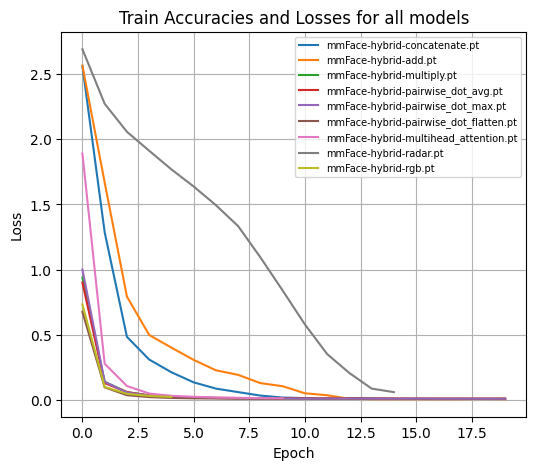

In [26]:
import matplotlib.pyplot as plt

model_names = ["mmFace-hybrid-concatenate.pt", "mmFace-hybrid-add.pt", "mmFace-hybrid-multiply.pt", "mmFace-hybrid-pairwise_dot_mean.pt", "mmFace-hybrid-pairwise_dot_max.pt", "mmFace-hybrid-pairwise_dot_flatten.pt", "mmFace-hybrid-multihead_attention.pt", "mmFace-hybrid-radar.pt", "mmFace-hybrid-rgb.pt"]

fig, axs = plt.subplots(1, 1, figsize=(6, 5), dpi=100)
plt.grid()
for mn in model_names:
    losses, train_acc, _ = load_history(f"models/{mn}")
    train_acc = np.array(train_acc)[:, 0]
    # axs[0].plot(range(len(train_acc)), train_acc, label=mn)
    # axs[0].set_xlabel("Epoch")
    # axs[0].set_ylabel("Accuracy (%)")

    # axs[1].plot(range(len(losses)), losses, label=mn)
    # axs[1].set_xlabel("Epoch")
    # axs[1].set_ylabel("Loss")
    axs.plot(range(len(losses)), losses, label=mn)
    axs.set_xlabel("Epoch")
    axs.set_ylabel("Loss")

plt.title(f"Train Accuracies and Losses for all models")
plt.legend(fontsize="7")

plt.show()

## Classic Testing and Evaluation

In [ ]:
preds_subject, preds_liveness = [], []
true_subject, true_liveness = [], []

model.eval()
with torch.no_grad():
    correct_s, correct_l, total_s, total_l = 0., 0., 0., 0.
    for radar, rgb_emb, labels_s, labels_l in test:
        out1, out2 = model(radar, rgb_emb)
        _, preds_s = torch.max(out1.data, 1)
        _, preds_l = torch.max(out2.data, 1)
        total_s += labels_s.size(0)
        total_l += labels_l.size(0)
        correct_s += (preds_s == labels_s).sum().item()
        correct_l += (preds_l == labels_l).sum().item()

        preds_subject.extend(preds_s.cpu().numpy())
        preds_liveness.extend(preds_l.cpu().numpy())
        true_subject.extend(labels_s.data.cpu().numpy())
        true_liveness.extend(labels_l.data.cpu().numpy())
        del radar, rgb_emb, labels_s, labels_l, out1, out2
    
    print(f"Test Accuracy (Subject): {100*correct_s/total_s:.4f}%")
    print(f"Test Accuracy (Liveness): {100*correct_l/total_l:.4f}%")

In [ ]:
import matplotlib.pyplot as plt

losses, train_acc, val_acc = load_history(f"models/{model_name}")

fig, axs = plt.subplots(1, 2, figsize=(10, 3), dpi=120)

axs[0].plot(range(len(train_acc)), train_acc)
axs[0].plot(range(len(val_acc)), val_acc)
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy (%)")

axs[1].plot(range(len(losses)), losses)
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")

axs[0].set_title(f"Train and Validation Accuracy and Loss ({model_name})")
plt.show()

### Subject Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import sys
sys.path.insert(1, "../../Soli/soli_realsense/")
from names import anon_names

# subject_names = np.array(anon_names)
subject_names = list(range(num_subjects))+["NONE"]

# Build confusion matrix
cf_matrix = confusion_matrix(preds_subject, true_subject)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index=subject_names, columns=subject_names)
plt.figure(figsize = (14, 5))
heatmap = sn.heatmap(df_cm, annot=True)
heatmap.set(xlabel ="Predictions", ylabel = "Actual", title ='Precision Confusion Matrix')

### Liveness Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

# Build confusion matrix
cf_matrix = confusion_matrix(preds_liveness, true_liveness)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index=["Real", "Fake"], columns=["Real", "Fake"])
plt.figure(figsize = (14, 5))
heatmap = sn.heatmap(df_cm, annot=True)
heatmap.set(xlabel ="Predictions", ylabel = "Actual", title ='Precision Confusion Matrix')